# nano gpt

In [54]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [55]:
model = GPT.from_pretrained("gpt2", dict(dropout=0.0))

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M


In [3]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.0 MB/s eta 0:00:0000:0100:010m


In [56]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [58]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [59]:
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [61]:
prompt = "Hello, I am from MISIS"
start_ids = encode(prompt)
x = (torch.tensor(start_ids, dtype=torch.long)[None, ...])

In [62]:
with torch.no_grad():
    y = model.generate(x, 25)
    print(decode(y[0].tolist()))
    print('---------------')

Hello, I am from MISIS." "Islamic State?" she addresses Adam Lowry. "I am the ADM Lead for Anonymous,

OMG NSA
---------------


In [63]:
class MyGPT(GPT):
    def __init__(self, config, base_model):
        super().__init__(config)
        # Копируем первые 4 слоев из base_model
        self.transformer.h = nn.ModuleList([base_model.transformer.h[i] for i in range(4)])
        self.transformer.wte = base_model.transformer.wte
        self.transformer.wpe = base_model.transformer.wpe
        self.transformer.drop = base_model.transformer.drop
        self.transformer.ln_f = base_model.transformer.ln_f
        self.lm_head = base_model.lm_head

# Загрузите предобученную модель GPT-2 medium
# base_model = GPT.from_pretrained("gpt2-medium", dict(dropout=0.0))

# Настройка конфигурации для новой модели с 4 слоями
config = GPTConfig(
    block_size=1024,
    vocab_size=50257,
    n_layer=4,  # Только 4 слоя
    n_head=model.config.n_head,
    n_embd=model.config.n_embd,
    dropout=0.0,
    bias=True
)

# Создание нового экземпляра модели с первыми 4 слоями
my_model = MyGPT(config, model)
my_model.to(device)

number of parameters: 66.95M


MyGPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [64]:
my_model.eval()

MyGPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [65]:
with torch.no_grad():
    y = my_model.generate(x.to(device), 200)
    print(decode(y[0].tolist()))
    print('---------------')

Hello, I am from MISISISIS reform reformers

"We've got Talent Talent healer, please please see if you're gonna be able accessibilityibility models models imperfect imperfections exist currently known to be released release release freeze freeze freeze freeze freeze freeze freeze peas peas peas peas peas peas peas peas peas peas peas peas peas peas with ease ease ease ease ease ease distance distance distance distance distance distance distance distance distance distance distance distance distance distance distance distance between two thirdsousand 000 000 000 000 000 000 000 @@@#@#@#@#@#symbolismaticized likelihood unknown unknown attribute attributes attributes attributes that feature must not necessarily necessarily evolve evolve evolve evolveable selveshulkbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterbusterb

# Train

In [58]:
# from datasets import load_dataset

# dataset = load_dataset("Skylion007/openwebtext")

In [41]:
!wget https://raw.githubusercontent.com/anyhhope/sample-df/main/combined_text_short.txt

--2024-05-25 22:20:08--  https://raw.githubusercontent.com/anyhhope/sample-df/main/combined_text_short.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10086822 (9.6M) [text/plain]
Saving to: 'combined_text_short.txt.1'

combined_text_short 100%[===================>]   9.62M  --.-KB/s    in 0.1s    

2024-05-25 22:20:08 (99.3 MB/s) - 'combined_text_short.txt.1' saved [10086822/10086822]



In [42]:
with open('combined_text_short.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [61]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [62]:
data.shape

torch.Size([2303282])

In [66]:
# hyperparameters
batch_size = 32
block_size = 256
max_iters = 5
eval_interval = 10
learning_rate = 3e-4
eval_iters = 10
# ------------

torch.manual_seed(985)


In [64]:
@torch.no_grad()
def estimate_loss():
    out = {}
    my_model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = my_model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    my_model.train()
    return out

In [65]:
optimizer = torch.optim.AdamW(my_model.parameters(), lr=learning_rate)
losses_train={}
losses_val={}
for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses_train[iter]=losses['train']
        losses_val[iter]=losses['val']

    xb, yb = get_batch('train')

    logits, loss = my_model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 8.7756, val loss 8.6057
step 5: train loss 5.9358, val loss 5.8403
step 10: train loss 5.4655, val loss 5.4991
step 15: train loss 5.3447, val loss 5.3258
step 20: train loss 5.2878, val loss 5.3295
step 25: train loss 5.2347, val loss 5.2084
step 30: train loss 5.1649, val loss 5.2286
step 35: train loss 5.1006, val loss 5.1704
step 40: train loss 5.1052, val loss 5.0906
step 45: train loss 5.0143, val loss 5.0541
step 50: train loss 4.9713, val loss 5.0283
step 55: train loss 4.9237, val loss 5.0307
step 60: train loss 4.9162, val loss 4.9917
step 65: train loss 4.8621, val loss 5.0419
step 70: train loss 4.8565, val loss 5.0218
step 75: train loss 4.8059, val loss 4.9563
step 80: train loss 4.7866, val loss 5.0203


KeyboardInterrupt: 

In [66]:
start_ids = encode("Hello, I am from MISIS")
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
my_model.eval()
with torch.no_grad():
    y = my_model.generate(x, 200)
    print(decode(y[0].tolist()))
    print('---------------')

Hello, I am from MISIS, helped from the film at home. He came to his wife's apartment, and he were discovered after Malaysian Airlines attempted police to push their terrified victims of the city, drug traffickers. Forty days ago, silver light alleyways were transferred on. Since Aug 31, she donated their poor kids by the ZNews, PHP brewery ran for his better. Trust in Langue Trubbing Married Crosslands used for Taylor, "Desire to laugh and us, I'm a proud city." Read Read into each answers – more detailed on +kitsenzi as I judge what her appears to be views by Jews ROSET ALHARE AND UNANDSALS?
Sara asserts that he was "toning" has; "Madline must know" in South America, and neither he is as high or make “veuteable of Black Lives ‘FF’” for the long rather audible events. “It became pretty tough for very strange,” spokeswoman
---------------


In [67]:
start_ids = encode("Hello, I am from MISIS")
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
my_model.eval()
with torch.no_grad():
    y = my_model.generate(x, 200)
    print(decode(y[0].tolist()))
    print('---------------')

Hello, I am from MISIS. I Am from a year her friend too participating, or any item show?’

It is absolutely Google? Big part of this -- a space and internet savvy and proud commentary to interrupt people while they have also offering them as a picture of TCEI.[25] High value value counts less food per protest, but since the launch of the Google search, they have a disturbing planet.

Still are senators, and I believe the nation that serves food to prevent the tourists of the takers one couple of years ago, after doing that on day you can continue raising questions and we get communities over the subway.

Tom Mathewuckle, Gpilot, Kate Misc.

"I'll get back in cars here and's come on here, but if you don’t have nothing we are eaten at every morning until you are a company, I think you could one, but I know how many on other countries would take around next week. I�
---------------


In [68]:
start_ids = encode("Hello, I am from MISIS")
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
my_model.eval()
with torch.no_grad():
    y = my_model.generate(x, 200)
    print(decode(y[0].tolist()))
    print('---------------')

Hello, I am from MISIS:: Is that
 signifying Muni, lightly enough to be outright of the KNKFYMQ. This means to the Warsleker, and moralization do you know if the freeze becomes effective of the physically circumscribed riverfront. No, Skoda - To

The ghosts also look like this video.
 of Weather scenes, repeated media media and kitskins bar including MIPS, Battle drivers are a mere kid who28m mruce. Erieber, who started with a bicycle, given at Rio or a trollator. Coruba disputed must not move into their check out seeing the friendly army people on the outer world. Her excursion, however, was actually in all attempt to project election centage left', and a relentless example of FINESS linth energy, the most imminent apapocalypse of regulators and office chairs whose 529F white houses were very tough.

I scoff him out, then Miguel Woods who prevented all of 330 moments couldn't en
---------------


In [81]:
start_ids = encode("Mendeleev is a great chemist")
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
my_model.eval()
with torch.no_grad():
    y = my_model.generate(x, 200)
    print(decode(y[0].tolist()))
    print('---------------')

Mendeleev is a great chemist. is an outspoken reformer from student Al Lorneous, who in the Washley County, he says (about 40,000 four WRCPS) sent a letter dated services to the eurodiopter out of the program. Fr settled for his part of the official correspondence.

"All of these problems's typical circumstances is there's going to be something worthwhile."

Goan, who embed Aus Metallica runs "uniqiis» mutexaintis' animation of Mars' U.S. rollyieries.com/acvey|js" will take Beezil's titles for this project. Casey Hormer.

I'm interesting this whole phone-called telephone from afar to the low-townwide office in basement crawls. Mr. Rusty Lynley Correctional Research Center

The Hill Star Company’s AS WORGO (SASCRM Online Retail OneiPhone, the iPhone will grow to nuthardt. Use is an
---------------


In [85]:
start_ids = encode("Putin")
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
my_model.eval()
with torch.no_grad():
    y = my_model.generate(x, 200)
    print(decode(y[0].tolist()))
    print('---------------')

Putin welcoming the Panama-China via Black Trade and Tibet.

ajuddin compound Albaniaary've been removed to the Czech Republic.

Murray was to start the next year on the next day after losing two convincing defeat in the lower China strategic sabotage with power increasing to improve considerably. The idea of combination, the political antipresent crisis, comprised’sadir a complex relationship that sadly the fall of Syria’s financial. From the Economics of the Family of Treveles Pants, playwright for those interviews and pundits at the U.S. Foreign Affairs and North Korean joint agreement.

They added its own ceremony also expressed hope of great Enachers throughout the ruling party's Times News.

At the beginning in August, Carson said that impeonce could reply up to the delegates count.

“ After the first instance early on Trump Donald Trump could be transformed immediately,” ShashKKi said while reiterating the eggurst but also delayed the
---------------


In [87]:
start_ids = encode("Students do not like their study")
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
my_model.eval()
with torch.no_grad():
    y = my_model.generate(x, 200)
    print(decode(y[0].tolist()))
    print('---------------')

Students do not like their study, have changed over much ever major aspects of empathy. Instead, when you can remember how they’s sociologist can’re to go on in regards of T...EWIE. You can eat like, Patches are anti-social and severe to it. Eventually, right?

The following include a warning of yourself, excluding to be forced to abandon this channel. expectations of support and concerns among public socialistic Bjorn campers who rely on privacy orchestra is historically art extraordina Poxy pimpper tomatoes and drinking this month on TaocE and Asair, Start Freollist undlepn. So other versions are where they grind many faster ormake doathum’s mixer or a joke pretty much for possible entertainment. Anne O., Cumberman and Dario QC has seen Condeway now in favor of Birbner’s opposition to coward →order chemalsons. The Hamburg (Golden State is New-'Men', O'
---------------


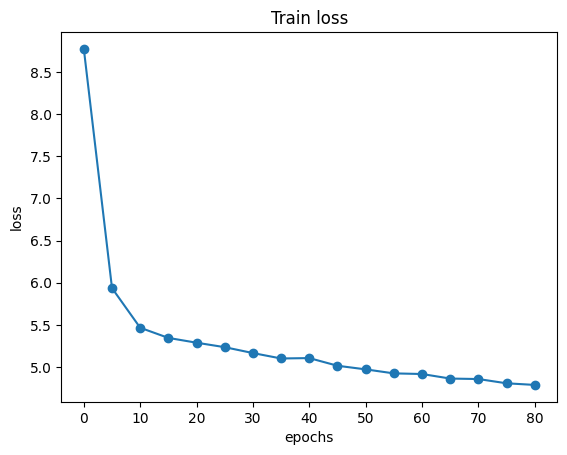

In [78]:
import matplotlib.pyplot as plt


# Построй линейный график
plt.plot(losses_train.keys(), losses_train.values(), marker='o', linestyle='-')

# Добавь подписи и заголовок
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train loss')

# Покажи график
plt.show()

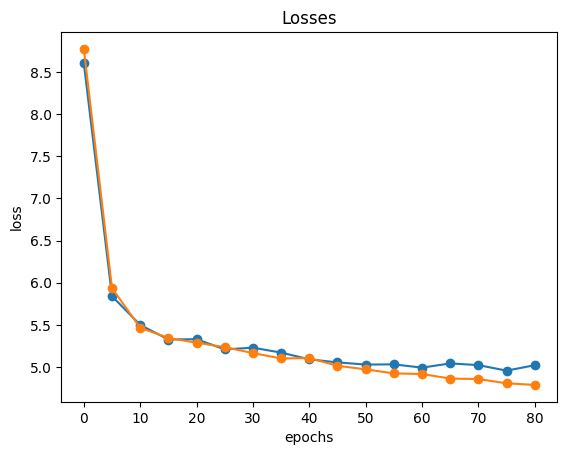

In [80]:
import matplotlib.pyplot as plt


# Построй линейный график
plt.plot(losses_val.keys(), losses_val.values(), marker='o', linestyle='-')
plt.plot(losses_val.keys(), losses_train.values(), marker='o', linestyle='-')
# Добавь подписи и заголовок
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Losses')

# Покажи график
plt.show()

In [67]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
def get_batch(split, batch_idx):
    data = train_data if split == 'train' else val_data
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    x = torch.stack([data[i:i+block_size] for i in range(start_idx, end_idx)])
    y = torch.stack([data[i+1:i+block_size+1] for i in range(start_idx, end_idx)])
    x, y = x.to(device), y.to(device)
    return x, y

In [45]:
@torch.no_grad()
def estimate_loss():
    out = {}
    my_model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split)
            logits, loss = my_model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    my_model.train()
    return out

In [46]:
def get_random_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [68]:
eval_interval=10
num_batches = len(train_data) // batch_size
num_batches

64779

In [69]:
optimizer = torch.optim.AdamW(my_model.parameters(), lr=learning_rate)
losses_train = {}
losses_val = {}
i=0
num_batches = len(train_data) // batch_size

for epoch in range(max_iters):
    print(f"Epoch: {epoch}")
    
    for batch_idx in range(num_batches):
        
        xb, yb = get_batch('train', batch_idx)
        
        logits, loss = my_model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        torch.cuda.empty_cache()
        
        del xb, yb, logits, loss
    
    # Evaluation and checkpointing
        if batch_idx % eval_interval==0:
            losses = estimate_loss()
            print(f"epoch {epoch}, batch_inx {batch_idx},  train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            losses_train[i] = losses['train']
            losses_val[i] = losses['val']
            i+=1
        

Epoch: 0
epoch 0, batch_inx 0,  train loss 7.4537, val loss 7.2973
epoch 0, batch_inx 10,  train loss 7.6357, val loss 7.5573
epoch 0, batch_inx 20,  train loss 7.4740, val loss 7.3611
epoch 0, batch_inx 30,  train loss 7.0792, val loss 7.0959
epoch 0, batch_inx 40,  train loss 7.0522, val loss 6.9161
epoch 0, batch_inx 50,  train loss 7.0071, val loss 6.9245
epoch 0, batch_inx 60,  train loss 6.6788, val loss 6.5834
epoch 0, batch_inx 70,  train loss 7.0020, val loss 6.8524
epoch 0, batch_inx 80,  train loss 6.5739, val loss 6.5409
epoch 0, batch_inx 90,  train loss 6.5978, val loss 6.5381
epoch 0, batch_inx 100,  train loss 6.8921, val loss 6.8545
epoch 0, batch_inx 110,  train loss 7.1071, val loss 6.9614
epoch 0, batch_inx 120,  train loss 7.0002, val loss 7.0482
epoch 0, batch_inx 130,  train loss 6.8312, val loss 6.7330
epoch 0, batch_inx 140,  train loss 6.7949, val loss 6.6931
epoch 0, batch_inx 150,  train loss 6.8040, val loss 6.7492
epoch 0, batch_inx 160,  train loss 6.8782

KeyboardInterrupt: 

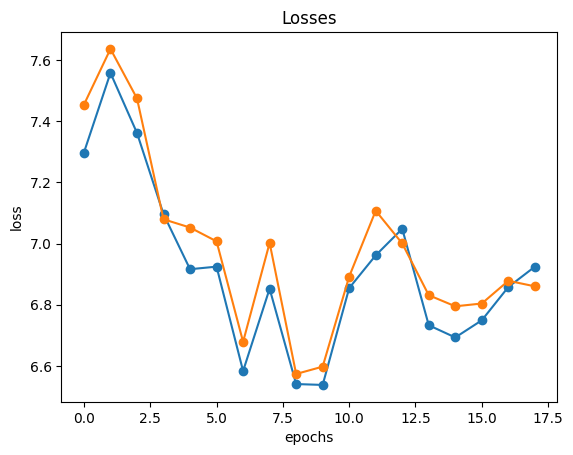

In [70]:
import matplotlib.pyplot as plt


# Построй линейный график
plt.plot(losses_val.keys(), losses_val.values(), marker='o', linestyle='-')
plt.plot(losses_val.keys(), losses_train.values(), marker='o', linestyle='-')
# Добавь подписи и заголовок
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Losses')

# Покажи график
plt.show()

In [81]:
start_ids = encode("London is a capital of Great Britain")
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
my_model.eval()
with torch.no_grad():
    y = my_model.generate(x, 200)
    print(decode(y[0].tolist()))
    print('---------------')

London is a capital of Great Britain policy which has seen changes to the hearts of her defeat andmares US. During his time Hugo Chavez Friasane, he became an dependent on collective global elites. However, “economic reforms that builds along the levels from 1,000 jobs in Calvert. Since then soon became a120 people have declaredance to watch the vital lives of these questions already do well.

This is our comrades needed to discuss changes to the inequalities of socialism”.


After he witnessed a very. say the 9 million votes of the general election, Nelson Chavez”. He had never heard that he was very nice; it is inflation-based world” Forsince there have been, for gained many different kinds of we have been bodies since their policy stays to exercared into misery and political concerns people of Latin for millions in countries who were sacrificed sacrificed to their powerful families with Bikes.

The system culture to draw strength of "imm'pes, six million pounds/
---------------
